# Web Log Anomaly Detection

### Import Modules

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Getting Spark Session

In [ ]:
spark = SparkSession.builder \
                    .master("spark://node-201:7077") \
                    .appName("Web Log Anomaly Detection") \
                    .config("spark.submit.deployMode", "client") \
                    .config("spark.executor.instances", "4") \
                    .config("spark.executor.memory", "8g") \
                    .config("spark.executor.cores", "8") \
                    .enableHiveSupport() \
                    .getOrCreate()

### Getting Spark Context

In [ ]:
sc = spark.sparkContext

### Apache Access Log Parser

In [ ]:
import re
from dateutil import parser
from pyspark.sql import Row

#APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)? ?(\S+)? ?(\S+)?" (\d{3}) ([\d-]+) ?"?([^"]+)?"? ?"?([^"]+)?"?'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] '
pattern = re.compile(APACHE_ACCESS_LOG_PATTERN)

def apache_access_log_parse(line):
    row = None

    try:
        m = pattern.match(line)

        time = m.group(4)
        time = parser.parse(time.replace(':', ' ', 1))

        #date = time.strftime('%Y%m%d')

        #size = m.group(9)
        #if size == '-': size = 0
        #else: size = long(size)

        row = Row(#host     = m.group(1),
                  #identity = m.group(2),
                  #user     = m.group(3),
                  time     = time)
                  #method   = m.group(5),
                  #url      = m.group(6),
                  #protocol = m.group(7),
                  #status   = m.group(8),
                  #size     = size,
                  #referer  = m.group(10),
                  #agent    = m.group(11),
                  #date     = date)
    except:
        print "apache access log parsing error : ", line

    return row

### Loading Data

In [ ]:
LOG_FILE_PATH = 'hdfs://node-201:9000/data/weblog/2015'
rdd = sc.textFile(LOG_FILE_PATH) \
        .map(apache_access_log_parse) \
        .filter(lambda x: x is not None)
df = spark.createDataFrame(rdd)

In [ ]:
df.show(10, False)

### 1. 요청 건수 이상 탐지

#### 데이터 전처리

In [ ]:
request_cnt_df = df.groupby('time').count().sort('time')

#### Pandas 로 변환

In [ ]:
request_cnt_pdf = request_cnt_df.toPandas()
request_cnt_pdf = request_cnt_pdf.set_index('time')

#### 이동 평균 추가

In [ ]:
request_cnt_pdf['MA20'] = request_cnt_pdf['count'].rolling(20).mean()
request_cnt_pdf['MS20'] = request_cnt_pdf['count'].rolling(20).std()

#### 체크포인트 생성/로드

In [2]:
request_cnt_pdf = pd.read_pickle('request_cnt_2015.pkl')
#request_cnt_pdf.to_pickle('request_cnt_2015.pkl')

#### 데이터 확인

In [70]:
print request_cnt_pdf.describe()
request_cnt_pdf.tail(10)

              count          MA20          MS20
count  3.486514e+06  3.486495e+06  3.486495e+06
mean   9.125499e+01  9.125528e+01  2.572619e+01
std    1.048811e+02  9.942676e+01  2.261026e+01
min    1.000000e+00  1.000000e+00  0.000000e+00
25%    4.000000e+00  4.100000e+00  2.214783e+00
50%    6.000000e+01  6.490000e+01  2.416016e+01
75%    1.410000e+02  1.430000e+02  3.886495e+01
max    1.212000e+03  7.894000e+02  2.237418e+02


,count,MA20,MS20
time,,,
2015-12-31 05:29:52,94,83.95,29.942884
2015-12-31 05:29:53,44,83.35,30.644438
2015-12-31 05:29:54,91,84.05,30.651651
2015-12-31 05:29:55,74,83.45,30.728822
2015-12-31 05:29:56,85,83.30,30.712761
2015-12-31 05:29:57,70,82.80,30.850403
2015-12-31 05:29:58,91,84.75,30.022579
2015-12-31 05:29:59,97,87.70,28.018979
2015-12-31 05:30:00,47,85.90,29.456301


#### 데이터 시각화

[anomaly points]
Series([], Name: count, dtype: int64)


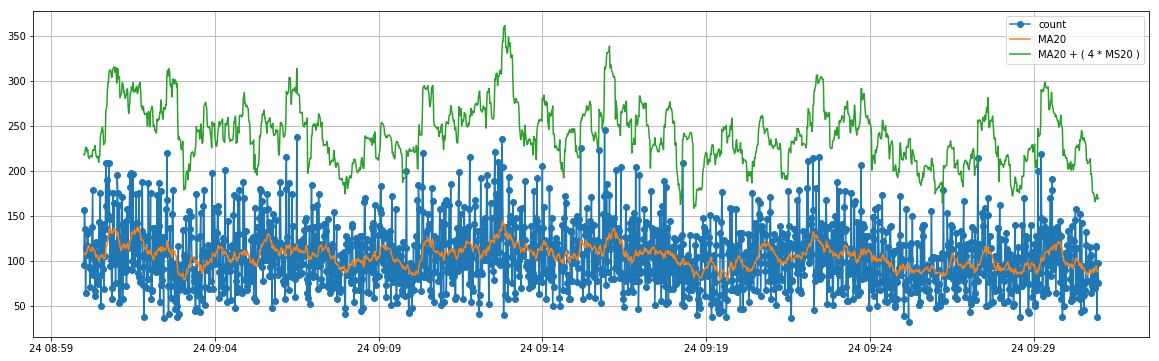

[anomaly points]
Series([], Name: count, dtype: int64)


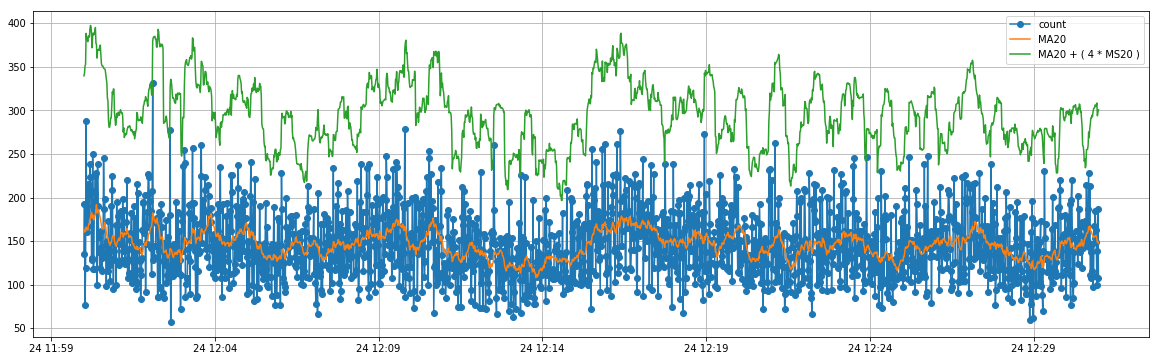

[anomaly points]
Series([], Name: count, dtype: int64)


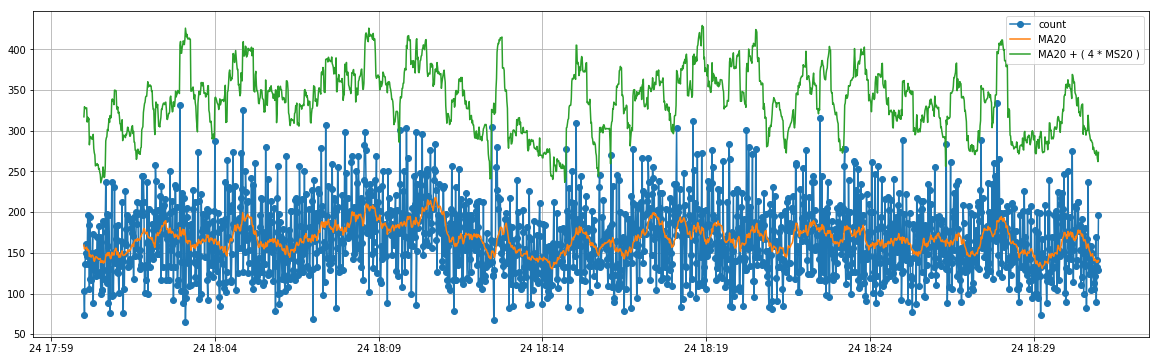

[anomaly points]
Series([], Name: count, dtype: int64)


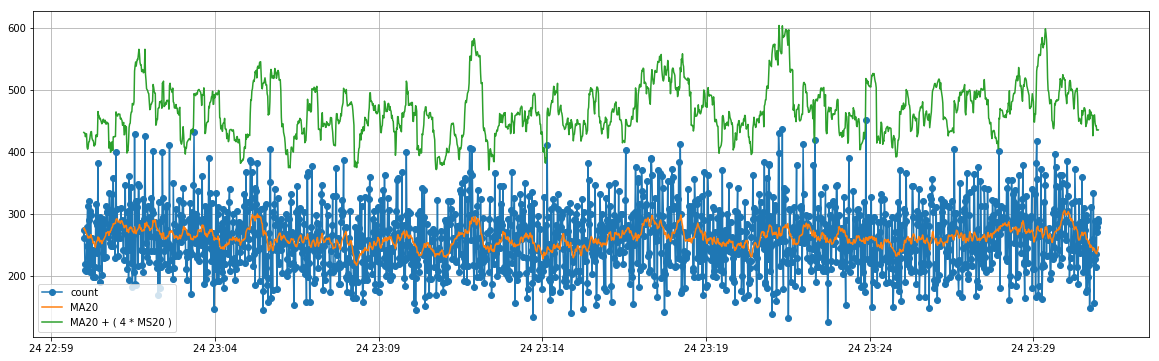

In [80]:
def plot(df):
    plt.figure(figsize=(20,6))
    plt.plot(df.index, df['count'], linestyle='solid', marker='o')
    plt.plot(df.index, df['MA20'], linestyle='solid')
    plt.plot(df.index, df['MA20']+(4*df['MS20']), linestyle='solid', label='MA20 + ( 4 * MS20 )')
    #anomaly = df['count'][df['count'] > df['MA20']+(4*df['MS20'])]
    #print anomaly
    #plt.plot(df.index, ?, marker='^', label='anomaly points')
    print "[anomaly points]"
    print df['count'][df['count'] > df['MA20']+(4*df['MS20'])]
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
plot(request_cnt_pdf['2015-12-24 09:00':'2015-12-24 09:30'])
plot(request_cnt_pdf['2015-12-24 12:00':'2015-12-24 12:30'])
plot(request_cnt_pdf['2015-12-24 18:00':'2015-12-24 18:30'])
plot(request_cnt_pdf['2015-12-24 23:00':'2015-12-24 23:30'])


####  이상 탐지

In [79]:
# 정렬
request_cnt_pdf[request_cnt_pdf['count'] > request_cnt_pdf['MA20']+(4*request_cnt_pdf['MS20'])].sort_values(['count'], ascending=[False])[:10]

# TODO : 값이 0인 경우도 고려
# 


,count,MA20,MS20
time,,,
2015-10-24 22:40:32,240,15.20,53.773012
2015-10-24 15:08:59,180,13.35,41.501141
2015-12-04 20:13:39,148,32.60,28.566451
2015-12-05 03:55:27,106,21.00,20.637217
2015-12-09 04:57:57,106,20.70,21.069059
2015-12-05 03:52:52,104,20.10,20.338970
2015-11-06 11:19:44,102,10.20,21.676084
2015-12-05 03:39:08,100,24.70,18.390787
2015-12-05 03:51:45,96,20.20,18.647986


[anomaly points]
time
2015-10-24 22:40:31     44
2015-10-24 22:40:32    240
Name: count, dtype: int64


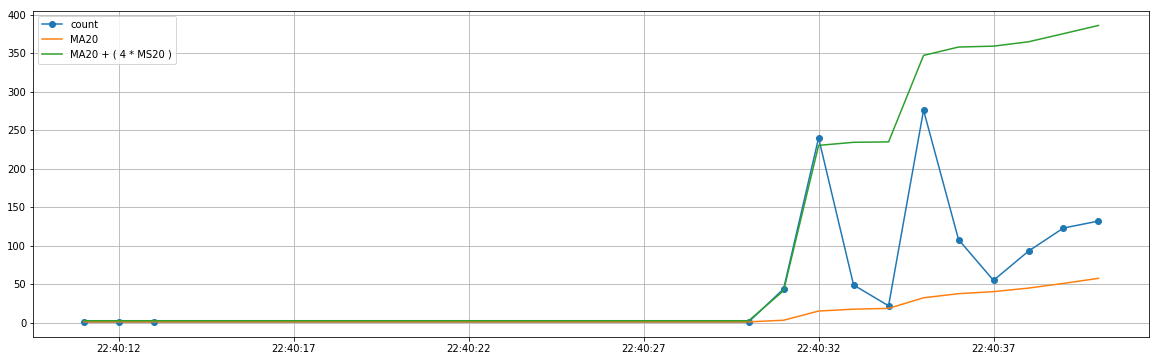

In [81]:
plot(request_cnt_pdf['2015-10-24 22:40:10':'2015-10-24 22:40:40'])

#### 평가

In [ ]:
# TODO

#### 파라미터 최적화
 - 이동 평균을 위한 윈도우 크기
 - 이동 표준편차를 위한 윈도우 크기
 - 시간축 해상도
 - threshold 설정 모델 (평균과 표준편차 계산식)

In [ ]:
# TODO

### 2. 클라이언트 수 이상 탐지

In [ ]:
# TODO

### 3. 응답 크기 이상 탐지

In [ ]:
# TODO

### 임시 코드

In [ ]:
# 이상 데이터 가상으로 추가
for i in range(100):
    r = np.random.random_sample()
    request_cnt_pdf['count'][15610+i] = 3000 * r
